# **DATA CLEANING🧼**

In [1]:
# Importing Keras
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout

from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit

# Importing TensorFlow
import tensorflow as tf

# Importing utils
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objs as go
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from collections import defaultdict

import numpy as np
import matplotlib
import time
import cv2
import os
from PIL import Image
from tqdm import tqdm  # Libreria per mostrare una barra di avanzamento
import random
import shutil

In [2]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'

In [3]:
def dhash(image, hash_size=8):
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

def find_duplicates(dataset_path):
    image_hashes = {}
    duplicates = []

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                h = dhash(image)

                if h in image_hashes:
                    duplicates.append((image_path, image_hashes[h]))
                else:
                    image_hashes[h] = image_path

    return duplicates

In [4]:
def remove_duplicates(duplicate_pairs):
    for pair in duplicate_pairs:
        os.remove(pair[0])

In [5]:
def image_resizer(paths):
    """
    This function resizes the input images
    """
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350,250)), paths))
    return resized_images

def plot_images_list(images, title, subtitle):
    '''
    This functions helps to plot a matrix of images in a list
    '''
    fig = sp.make_subplots(rows=3, cols=3)
    images = image_resizer(images)

    traces = []
    for i in range(min(9, len(images))):
        img = go.Image(z=images[i])
        traces.append((img, i//3+1, i%3+1))

    fig.add_traces([trace[0] for trace in traces],
                  rows = [trace[1] for trace in traces],
                  cols = [trace[2] for trace in traces])

    fig.update_layout(
        title={'text': f'<b>{title}<br>  <i><sub>{subtitle}</sub></i></b>',
               'font': dict(size = 22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color,paper_bgcolor=paper_color
        #template=template
    )
    fig.show()

In [6]:
# Funzione per aggiungere rumore gaussiano
def add_gaussian_noise(image, mean=0, std=25):
    gaussian_noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + gaussian_noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Funzione per aggiungere rumore sale e pepe
def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = np.copy(image)

    # Aggiungi rumore sale
    num_salt = np.ceil(salt_prob * image.size)
    coords_salt = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[coords_salt[0], coords_salt[1], :] = 255

    # Aggiungi rumore pepe
    num_pepper = np.ceil(pepper_prob * image.size)
    coords_pepper = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[coords_pepper[0], coords_pepper[1], :] = 0

    return noisy_image

def add_brightness_contrast(image, brightness=1, contrast=1.5):
    # Converti l'immagine in float32
    image = image.astype(np.float32)

    # Regola la luminosità e il contrasto
    image = image + brightness
    image = image * contrast

    # Assicurati che i valori rimangano nell'intervallo [0, 255]
    image = np.clip(image, 0, 255)

    # Converti l'immagine nuovamente in uint8
    image = image.astype(np.uint8)

    return image

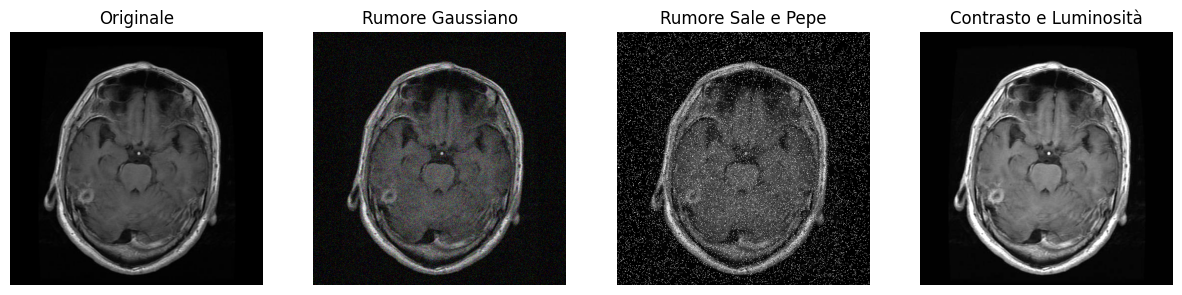

In [7]:
# Carica un'immagine di esempio
img_path = '/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Training/glioma_tumor/gg (11).jpg'
img = plt.imread(img_path)

# Applica rumore gaussiano
noisy_img_gaussian = add_gaussian_noise(img)

# Applica rumore sale e pepe
noisy_img_salt_pepper = add_salt_and_pepper_noise(img)

# Applica contrasto e luminosità
noisy_img_brightness = add_brightness_contrast(img)

# Visualizza le immagini
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Originale')

ax[1].imshow(noisy_img_gaussian)
ax[1].axis('off')
ax[1].set_title('Rumore Gaussiano')

ax[2].imshow(noisy_img_salt_pepper)
ax[2].axis('off')
ax[2].set_title('Rumore Sale e Pepe')

ax[3].imshow(noisy_img_brightness)
ax[3].axis('off')
ax[3].set_title('Contrasto e Luminosità')

plt.show()

In [8]:
# Loading training and testing directories
train_dir = '/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Training'
test_dir = '/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing'

In [9]:
# Giving names to each directory
directories = {
    train_dir: 'Training',
    test_dir: 'Test',
    }

# Naming subfolders
subfolders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)



* * * * * Number of files in each folder * * * * *


Training/glioma_tumor: 826

Training/meningioma_tumor: 822

Training/no_tumor: 398

Training/pituitary_tumor: 835

  Total: 2881
--------------------------------------------------------------------------------

Test/glioma_tumor: 100

Test/meningioma_tumor: 115

Test/no_tumor: 105

Test/pituitary_tumor: 74

  Total: 394
--------------------------------------------------------------------------------


In [10]:
# Trovare i duplicati
dataset_path = '/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset'
duplicate_pairs = find_duplicates(dataset_path)

# Mostrarli
for duplicate_pair in duplicate_pairs:
    print(f'Duplicate: {duplicate_pair[0]} and {duplicate_pair[1]}')

# Eliminarli
remove_duplicates(duplicate_pairs)

Duplicate: /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pituitary_tumor/image(85).jpg and /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pituitary_tumor/image(86).jpg
Duplicate: /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pituitary_tumor/image(28).jpg and /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pituitary_tumor/image(27).jpg
Duplicate: /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pituitary_tumor/image(81).jpg and /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pituitary_tumor/image(82).jpg
Duplicate: /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pituitary_tumor/image(48).jpg and /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pituitary_tumor/image(47).jpg
Duplicate: /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pituitary_tumor/image(56).jpg and /content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing/pitui

In [11]:
# Verificare l'eliminazione
print("\nIf empty, means all duplicates has been removed:\n{")
duplicate_pairs = find_duplicates(dataset_path)
print("}")


If empty, means all duplicates has been removed:
{
}


In [12]:
# Giving names to each directory
directories = {
    train_dir: 'Training',
    test_dir: 'Test',
    }

# Naming subfolders
subfolders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


Training/glioma_tumor: 802

Training/meningioma_tumor: 707

Training/no_tumor: 246

Training/pituitary_tumor: 798

  Total: 2553
--------------------------------------------------------------------------------

Test/glioma_tumor: 84

Test/meningioma_tumor: 113

Test/no_tumor: 81

Test/pituitary_tumor: 36

  Total: 314
--------------------------------------------------------------------------------


# **EDA🔍**

In [13]:
unique_dimensions = set()

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)

if len(unique_dimensions) == 1:
    print(f"\nAll images have the same dimensions: {unique_dimensions.pop()}")
else:
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")


Found 440 unique image dimensions: {(491, 624), (206, 244), (409, 442), (503, 369), (430, 483), (728, 725), (201, 251), (289, 354), (383, 407), (554, 554), (236, 226), (214, 216), (229, 214), (334, 407), (733, 781), (229, 223), (235, 257), (329, 310), (411, 501), (645, 439), (434, 512), (227, 262), (528, 528), (590, 332), (209, 241), (407, 485), (300, 359), (630, 423), (565, 513), (236, 203), (502, 502), (236, 221), (236, 239), (550, 664), (226, 213), (411, 496), (1024, 830), (374, 456), (235, 261), (329, 314), (355, 452), (626, 686), (276, 326), (300, 345), (210, 213), (359, 449), (337, 412), (201, 250), (221, 228), (305, 325), (236, 216), (225, 225), (202, 223), (410, 490), (605, 613), (216, 234), (208, 248), (350, 350), (444, 506), (388, 453), (450, 446), (197, 229), (442, 442), (534, 674), (257, 307), (421, 486), (402, 396), (224, 219), (341, 377), (926, 649), (310, 380), (421, 504), (213, 237), (341, 395), (825, 993), (236, 220), (447, 251), (235, 233), (622, 777), (494, 600), (2

In [14]:
# Checking if all the images in the dataset have the same dimensions
dims_counts = defaultdict(int)

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                dims_counts[img.size] += 1

for dimension, count in dims_counts.items():
    print(f"\nDimension {dimension}: {count} images")


Dimension (512, 512): 2283 images

Dimension (257, 320): 1 images

Dimension (825, 993): 1 images

Dimension (507, 340): 1 images

Dimension (420, 264): 1 images

Dimension (324, 284): 1 images

Dimension (552, 527): 1 images

Dimension (226, 212): 1 images

Dimension (225, 225): 30 images

Dimension (306, 365): 1 images

Dimension (216, 234): 1 images

Dimension (300, 359): 1 images

Dimension (503, 369): 1 images

Dimension (507, 362): 1 images

Dimension (272, 331): 1 images

Dimension (230, 241): 1 images

Dimension (298, 354): 1 images

Dimension (497, 320): 1 images

Dimension (374, 456): 1 images

Dimension (329, 314): 1 images

Dimension (1275, 1427): 1 images

Dimension (485, 510): 1 images

Dimension (254, 325): 1 images

Dimension (202, 223): 1 images

Dimension (250, 270): 1 images

Dimension (226, 223): 1 images

Dimension (229, 223): 1 images

Dimension (180, 218): 1 images

Dimension (209, 225): 1 images

Dimension (513, 522): 1 images

Dimension (450, 446): 1 images

D

In [15]:
# Checking images dtype
all_uint8 = True
all_in_range = True

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                img_array = np.array(img)

            if img_array.dtype == 'uint8':
                all_uint8 = False

            if img_array.min() < 0 or img_array.max() > 255:
                all_in_range = False

if all_uint8:
    print(" - All images are of data type uint8\n")
else:
    print(" - Not all images are of data type uint8\n")

if all_in_range:
    print(" - All images have pixel values ranging from 0 to 255")
else:
    print(" - Not all images have the same pixel values from 0 to 255")

 - Not all images are of data type uint8

 - All images have pixel values ranging from 0 to 255


In [16]:
# Loading the directory for each class in the training dataset
train_glioma_dir = train_dir + "/" + 'glioma_tumor'
train_meningioma_dir = train_dir + "/" + 'meningioma_tumor'
train_no_dir = train_dir + "/" + 'no_tumor'
train_pituitary_dir = train_dir + "/" + 'pituitary_tumor'

# Selecting 9 random pictures from each directory
glioma_files = random.sample(os.listdir(train_glioma_dir), 9)
meningioma_files = random.sample(os.listdir(train_meningioma_dir), 9)
no_files = random.sample(os.listdir(train_no_dir), 9)
pituitary_files = random.sample(os.listdir(train_pituitary_dir), 9)

In [17]:
# Plotting glioma tumors
glioma_images = [os.path.join(train_glioma_dir, f) for f in glioma_files]
plot_images_list(glioma_images, "Glioma Tumors", "Training Dataset")

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Plotting meningioma tumors
meningioma_images = [os.path.join(train_meningioma_dir, f) for f in meningioma_files]
plot_images_list(meningioma_images, "Meningioma Tumors", "Training Dataset")

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# Plotting no tumors
no_images = [os.path.join(train_no_dir, f) for f in no_files]
plot_images_list(no_images, "No Tumors", "Training Dataset")

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# Plotting pituarity tumors
pituitary_images = [os.path.join(train_pituitary_dir, f) for f in pituitary_files]
plot_images_list(pituitary_images, "Pituitary Tumors", "Training Dataset")

Output hidden; open in https://colab.research.google.com to view.